In [47]:
# Import all necessary libraries
import yfinance as yf

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input

In [3]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'DIS'

#last 5 years data with interval of 1 day
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)
df = yf.download(stock_symbol, start=start, end=end,actions=False)

type(df)

[*********************100%%**********************]  1 of 1 completed


pandas.core.frame.DataFrame

In [4]:
df1=df.reset_index()['Close']

In [5]:
df1.tail

<bound method NDFrame.tail of 0       131.669998
1       134.610001
2       134.490005
3       136.550003
4       137.839996
           ...    
1254     90.820000
1255     89.739998
1256     90.720001
1257     89.919998
1258     90.559998
Name: Close, Length: 1259, dtype: float64>

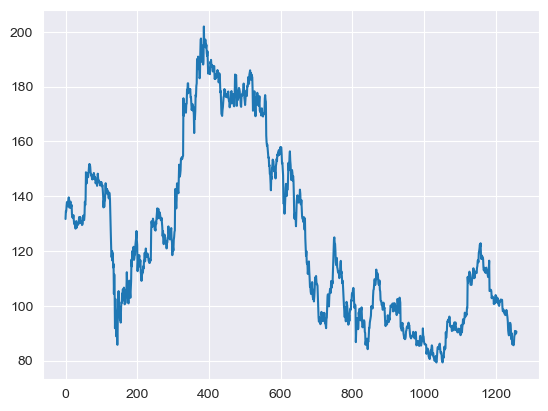

In [6]:
plt.plot(df1)

In [7]:
df1.shape

(1259,)

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1259, 1)

In [9]:
print(df1)

[[0.42703317]
 [0.45101557]
 [0.45003674]
 ...
 [0.09299291]
 [0.08646707]
 [0.09168772]]


In [10]:
##splitting dataset into train and test split
training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]

In [11]:
training_size, test_size

(818, 441)

In [12]:
train_data

array([[0.42703317],
       [0.45101557],
       [0.45003674],
       [0.4668407 ],
       [0.47736353],
       [0.47263229],
       [0.46488291],
       [0.47777142],
       [0.4855208 ],
       [0.49131252],
       [0.48543927],
       [0.46064109],
       [0.46390408],
       [0.47459008],
       [0.4788319 ],
       [0.46072275],
       [0.46488291],
       [0.46888002],
       [0.44032957],
       [0.43192759],
       [0.43347749],
       [0.42948038],
       [0.43861649],
       [0.42377031],
       [0.41308431],
       [0.41602093],
       [0.4097398 ],
       [0.40639529],
       [0.39831954],
       [0.41561304],
       [0.42075204],
       [0.40092993],
       [0.40794519],
       [0.40802672],
       [0.41357372],
       [0.41096334],
       [0.41145275],
       [0.4204258 ],
       [0.43274324],
       [0.42067051],
       [0.41553139],
       [0.43298795],
       [0.4226283 ],
       [0.41553139],
       [0.42075204],
       [0.41773389],
       [0.40916873],
       [0.410

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [49]:
from keras.src.utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping

### Create the Stacked LSTM model
# Compile the model
# Ensure model is built

model=Sequential()
model.add(Input(shape=(100, 1)))  # Input shape: (timesteps, features)
model.add(LSTM(50,return_sequences=True, activation = 'relu'))
model.add(LSTM(50,return_sequences=True, activation = 'relu'))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='MeanSquaredError',optimizer='adam', metrics = ['MeanSquaredError'])
model.build((None, X_train.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_MeanSquaredError', patience=10, restore_best_weights=True,mode='min')

In [50]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest), epochs=100,batch_size=64,verbose=1, callbacks=[early_stopping])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - MeanSquaredError: 0.2316 - loss: 0.2316 - val_MeanSquaredError: 0.1214 - val_loss: 0.1214
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - MeanSquaredError: 0.0440 - loss: 0.0440 - val_MeanSquaredError: 0.0270 - val_loss: 0.0270
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - MeanSquaredError: 0.0197 - loss: 0.0197 - val_MeanSquaredError: 0.0189 - val_loss: 0.0189
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - MeanSquaredError: 0.0080 - loss: 0.0080 - val_MeanSquaredError: 0.0045 - val_loss: 0.0045
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - MeanSquaredError: 0.0057 - loss: 0.0057 - val_MeanSquaredError: 0.0021 - val_loss: 0.0021
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - MeanSquaredError: 0.0052 - loss: 0.0052 - val_MeanSquaredError: 0.0039 - val_loss: 0.0039
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - MeanSquaredError: 0.0043 - loss: 0.0043 - val_MeanSquaredError: 0.0036 - v

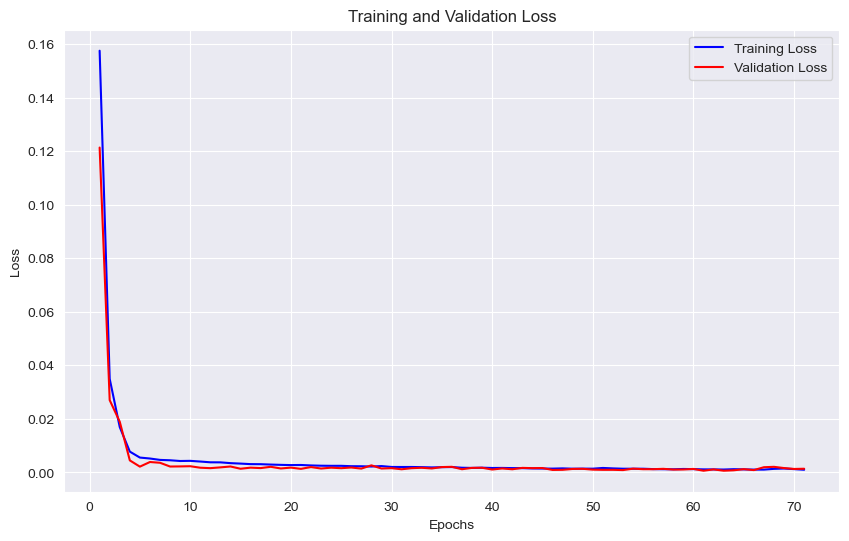

In [52]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
history_dict = history.history

# Extract loss values
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
import tensorflow as tf

In [54]:
tf.__version__

'2.17.0'

In [55]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [56]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [57]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

143.2861171062706

In [58]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

96.7659612158197

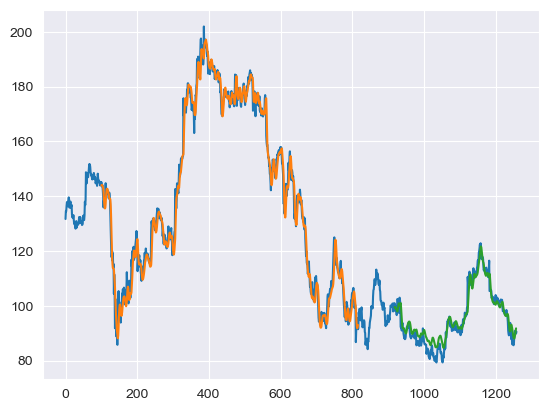

In [59]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [60]:
len(test_data)

441

In [61]:
x_input=test_data[-100:].reshape(1,0-1)
x_input.shape

(1, 100)

In [62]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [63]:
temp_input
len(temp_input)

100

In [64]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.10673483]
101
1 day input [0.30810013 0.31862302 0.31022104 0.31527857 0.30891591 0.30858961
 0.28297578 0.27432903 0.2819153  0.27424751 0.27008728 0.27155559
 0.26649806 0.28052858 0.2822416  0.27286072 0.27253449 0.26723225
 0.25923809 0.25418062 0.27163718 0.28012075 0.30304267 0.21266008
 0.21306797 0.21600459 0.215923   0.2162493  0.21233378 0.191288
 0.19618242 0.19520352 0.19234849 0.19324579 0.19332732 0.17407622
 0.1830492  0.18859615 0.17587076 0.18255972 0.20058735 0.191288
 0.19585612 0.18092829 0.17856268 0.18125459 0.19104329 0.17578924
 0.17521823 0.16942651 0.16844768 0.18109141 0.18092829 0.18370174
 0.18720937 0.18484381 0.18663836 0.18647524 0.18639365 0.16290073
 0.15270414 0.15229625 0.15735378 0.15229625 0.14723878 0.14462846
 0.14397586 0.14095765 0.14528099 0.14316015 0.15621177 0.1467493
 0.14250755 0.13394239 0.12080918 0.09478752 0.08548824 0.08067541
 0.08654866 0.10457622 0.11803573 0.11722002 0.11199937 0.08361204
 0.06901051 0.08687496 0.05416428 0.05

In [65]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [66]:
len(df1)

1259

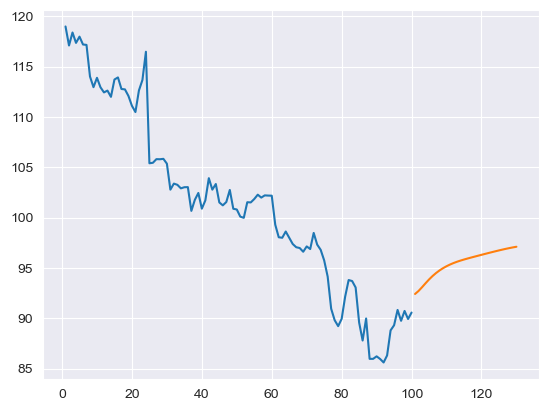

In [67]:
plt.plot(day_new,scaler.inverse_transform(df1[-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

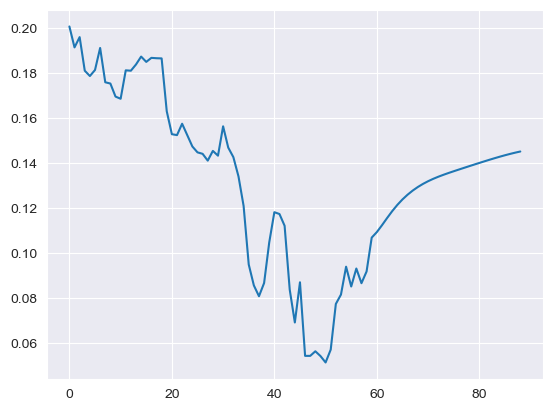

In [68]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [44]:
df3=scaler.inverse_transform(df3).tolist()

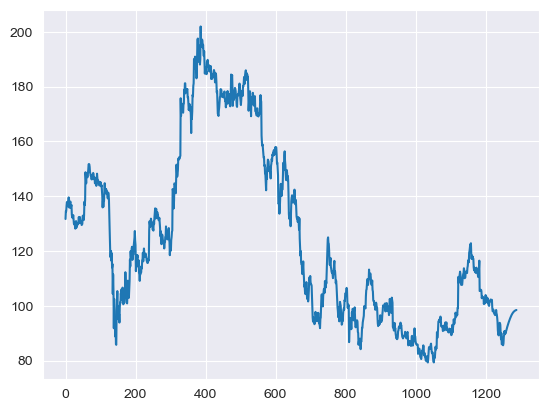

In [45]:
plt.plot(df3)